# BERT-based Emotion Classification

Labels: `anxiety`, `bipolar`, `depression`, `fear`, `grateful`, `happy`, `sad`, `stress`

### Import

In [1]:
import warnings
warnings.filterwarnings(
    "ignore", 
    category=FutureWarning, 
    message="`torch.cuda.amp.autocast.*` is deprecated"
)

In [2]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
from torch.utils.data import Dataset, DataLoader, TensorDataset

from transformers import AutoTokenizer, AutoModel

### Loading Data & Base Model

In [3]:
df = pd.read_csv("/kaggle/input/emotion-detection/emotions_data_01.csv")
df.head(3)

,text,label
0,whos that cutie,grateful
1,doesnt help that its not actually cheese looks...,grateful
2,im a slacker and im not a slacker im a slacker,stress


In [4]:
df.shape

(80000, 2)

In [5]:
df.label.value_counts()

label
grateful      10000
stress        10000
anxiety       10000
sad           10000
fear          10000
happy         10000
depression    10000
bipolar       10000
Name: count, dtype: int64

#### Base Model Loading

- BERT Model Loading
- Dataset Splitting
- Labels Encoding
- Tokenization
- Final Data Preparation

In [6]:
# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
transformer_model = AutoModel.from_pretrained("bert-base-uncased")

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# Convert text data to lists
train_texts = train_texts.tolist()
val_texts = val_texts.tolist()

# Convert labels to numerical format using LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)  # For classification tasks
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Tokenize the text data
train_encodings = tokenizer(
    train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt'
)
val_encodings = tokenizer(
    val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt'
)

# Create datasets
train_dataset = TensorDataset(
    train_encodings['input_ids'], train_encodings['attention_mask'], train_labels
)
val_dataset = TensorDataset(
    val_encodings['input_ids'], val_encodings['attention_mask'], val_labels
)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

print("Data preparation complete!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Data preparation complete!


### Helper Functions

#### Plotting Functions

In [7]:
def plot_metrics(history):
    """
    Function to plot training and validation loss and accuracy.
    
    Parameters:
        - history: Dictionary containing train/val loss and accuracy for each epoch.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Training Loss", marker='o')
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='o')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_accuracy"], label="Training Accuracy", marker='o')
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy", marker='o')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(history, num_classes, label_encoder=None):
    """
    Function to plot confusion matrix using Seaborn heatmap.

    Parameters:
        - history: Dictionary containing validation labels and predictions.
        - num_classes: The number of unique classes in the dataset.
        - label_encoder: LabelEncoder instance or list of original class names.

    Returns:
        - None
    """
    # Extract Data from History
    val_labels = np.array(history["all_val_labels"])
    val_predicted = np.array(history["all_val_predicted"])
    
    # Compute the confusion matrix
    cm = confusion_matrix(val_labels, val_predicted)

    # Get class names
    if label_encoder is not None:
        # Use inverse transform to map numeric labels back to class names
        if hasattr(label_encoder, "classes_"):  # If label_encoder is an instance of LabelEncoder
            class_names = label_encoder.classes_
        else:  # If label_encoder is a list of class names
            class_names = label_encoder
    else:
        # Default to encoded class indices
        class_names = [f'Class {i}' for i in range(num_classes)]

    # Plot the confusion matrix using Seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#### Training & Evaluation Functions

In [8]:
def train_one_epoch(model, train_dataloader, optimizer, criterion, device):
    """
    Function to train the model for one epoch.
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    
    train_progress = tqdm(train_dataloader, desc="Training", leave=False)
    for batch in train_progress:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
       
        labels = labels.to(device).long()
        outputs = outputs.float()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        
        # Update tqdm description
        train_progress.set_postfix(loss=loss.item())
    
    train_loss = total_loss / len(train_dataloader)
    train_accuracy = total_correct / len(train_dataloader.dataset)
    return train_loss, train_accuracy

def validate_one_epoch(model, val_dataloader, criterion, device, num_classes):
    """
    Function to validate the model for one epoch and generate a classification report.
    """
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    val_predicted = []
    val_labels = []
    
    val_progress = tqdm(val_dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for batch in val_progress:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            labels = labels.to(device).long()
            
            outputs = outputs.float()
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
            val_predicted.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            # Update tqdm description
            val_progress.set_postfix(loss=loss.item())
    
    val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = total_val_correct / len(val_dataloader.dataset)
    
    # Generate classification report
    val_predicted = np.array(val_predicted)
    val_labels = np.array(val_labels)
    
    report = classification_report(
        val_labels,
        val_predicted,
        target_names=[f'Class {i}' for i in range(num_classes)]
    )
    return val_loss, val_accuracy, report, val_predicted, val_labels

def train_model(
    model_class,
    transformer_model,
    train_dataloader,
    val_dataloader,
    optimizer_class,
    criterion_class,
    device,
    num_epochs,
    num_classes,
):
    """
    Function to train and validate the model for multiple epochs.
    Tracks training and validation loss and accuracy for plotting.
    Prints classification report after each epoch
    Returns the trained model and metrics history.
    """
    # Initialize model with num_classes
    model = model_class(transformer_model, num_classes).to(device)
    
    # Enable multi-GPU training
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for training.")
        model = nn.DataParallel(model)
    
    # Define optimizer and loss function
    optimizer = optimizer_class(model.parameters())
    criterion = criterion_class()

    # To store metrics
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "all_val_labels": [],
        "all_val_predicted": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training
        train_loss, train_accuracy = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        
        # Validation and classification report
        val_loss, val_accuracy, report, val_predicted, val_labels = validate_one_epoch(model, val_dataloader, criterion, device, num_classes)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        print(f"Classification Report:\n{report}")

        # Store metrics
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)
        history["all_val_labels"].extend(val_labels)
        history["all_val_predicted"].extend(val_predicted)

    print("Training complete!")
    return model, history

### Model 01

In [9]:
class EmotionClassifier(nn.Module):
    def __init__(self, transformer_model, num_classes):
        super(EmotionClassifier, self).__init__()
        self.transformer = transformer_model
        self.fc = nn.Linear(768, num_classes)  
        
    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output 
        logits = self.fc(pooled_output)
        return logits

In [10]:
# Parameters
num_epochs = 5
num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and store the model and metrics history
model_1, history_1 = train_model(
    model_class=EmotionClassifier,   # EmotionClassifier
    transformer_model=transformer_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer_class=lambda params: torch.optim.Adam(params, lr=1e-5),
    criterion_class=nn.CrossEntropyLoss,
    device=device,
    num_epochs=num_epochs,
    num_classes=num_classes
)

Using 2 GPUs for training.
Epoch 1/5


Training Loss: 0.8049, Accuracy: 0.7330


Validation Loss: 0.4990, Accuracy: 0.8360
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.68      0.81      0.74      2000
     Class 1       0.73      0.91      0.81      2000
     Class 2       0.96      0.78      0.86      2000
     Class 3       0.94      0.90      0.92      2000
     Class 4       0.81      0.86      0.84      2000
     Class 5       0.95      0.82      0.88      2000
     Class 6       0.92      0.90      0.91      2000
     Class 7       0.80      0.71      0.75      2000

    accuracy                           0.84     16000
   macro avg       0.85      0.84      0.84     16000
weighted avg       0.85      0.84      0.84     16000

Epoch 2/5


Training Loss: 0.4102, Accuracy: 0.8643


Validation Loss: 0.4041, Accuracy: 0.8706
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.82      0.78      2000
     Class 1       0.84      0.90      0.87      2000
     Class 2       0.94      0.88      0.91      2000
     Class 3       0.93      0.93      0.93      2000
     Class 4       0.83      0.86      0.85      2000
     Class 5       0.92      0.86      0.89      2000
     Class 6       0.96      0.90      0.93      2000
     Class 7       0.84      0.81      0.82      2000

    accuracy                           0.87     16000
   macro avg       0.87      0.87      0.87     16000
weighted avg       0.87      0.87      0.87     16000

Epoch 3/5


Training Loss: 0.3169, Accuracy: 0.8966


Validation Loss: 0.3973, Accuracy: 0.8769
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.81      0.79      2000
     Class 1       0.85      0.91      0.88      2000
     Class 2       0.96      0.87      0.91      2000
     Class 3       0.93      0.95      0.94      2000
     Class 4       0.84      0.85      0.84      2000
     Class 5       0.92      0.86      0.89      2000
     Class 6       0.97      0.90      0.93      2000
     Class 7       0.80      0.88      0.84      2000

    accuracy                           0.88     16000
   macro avg       0.88      0.88      0.88     16000
weighted avg       0.88      0.88      0.88     16000

Epoch 4/5


Training Loss: 0.2519, Accuracy: 0.9175


Validation Loss: 0.4040, Accuracy: 0.8812
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.81      0.79      2000
     Class 1       0.87      0.93      0.90      2000
     Class 2       0.93      0.90      0.92      2000
     Class 3       0.95      0.92      0.94      2000
     Class 4       0.81      0.88      0.84      2000
     Class 5       0.95      0.85      0.90      2000
     Class 6       0.96      0.90      0.93      2000
     Class 7       0.85      0.86      0.86      2000

    accuracy                           0.88     16000
   macro avg       0.89      0.88      0.88     16000
weighted avg       0.89      0.88      0.88     16000

Epoch 5/5


Training Loss: 0.1956, Accuracy: 0.9364


Validation Loss: 0.4300, Accuracy: 0.8793
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.85      0.78      2000
     Class 1       0.90      0.91      0.91      2000
     Class 2       0.96      0.87      0.91      2000
     Class 3       0.95      0.92      0.93      2000
     Class 4       0.87      0.82      0.85      2000
     Class 5       0.92      0.86      0.89      2000
     Class 6       0.96      0.90      0.93      2000
     Class 7       0.79      0.90      0.85      2000

    accuracy                           0.88     16000
   macro avg       0.89      0.88      0.88     16000
weighted avg       0.89      0.88      0.88     16000

Training complete!


#### Plotting Loss and Accuracy Curve

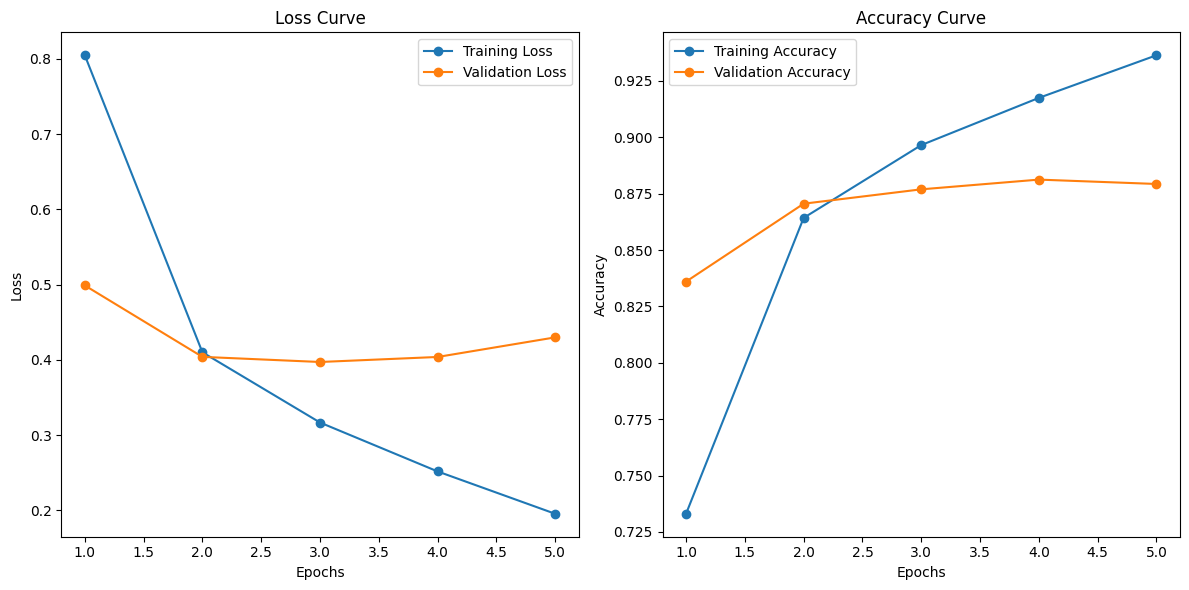

In [11]:
# Plot the training and validation curves
plot_metrics(history_1)

#### Plotting Confusion Matrix

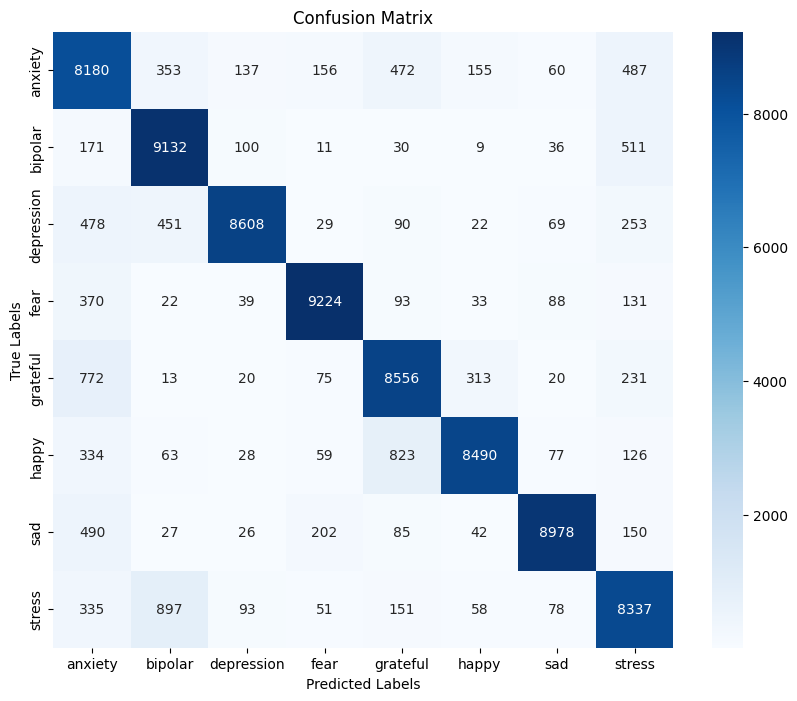

In [14]:
num_classes = 8
plot_confusion_matrix(history_1, num_classes, label_encoder=label_encoder)

#### Save Model 01 Locally

In [15]:
import os
import joblib
output_dir = "/kaggle/working/model_1"
os.makedirs(output_dir, exist_ok=True)

torch.save(model_1.state_dict(), f"{output_dir}/bert_emotion_classifier_v1.pt")
# torch.save(model_1.state_dict(), f"{output_dir}/bert_emotion_classifier_v1.bin")
tokenizer.save_pretrained(f"{output_dir}/bert_tokenizer") 
joblib.dump(label_encoder, f"{output_dir}/label_encoder.pkl")

['/kaggle/working/model_1/label_encoder.pkl']

#### Download Model 01

In [16]:
import shutil
shutil.make_archive("BERT_emotion_classifier_v1", 'zip', output_dir)

'/kaggle/working/BERT_emotion_classifier_v1.zip'

In [17]:
from IPython.display import FileLink
FileLink(r'BERT_emotion_classifier_v1.zip')

/kaggle/working/BERT_emotion_classifier_v1.zip

### Model 02

In [9]:
class EmotionClassifierWithConv(nn.Module):
    def __init__(self, transformer_model, num_classes, kernel_size=3, num_filters=256):
        super(EmotionClassifierWithConv, self).__init__()
        self.transformer = transformer_model
        self.conv = nn.Conv1d(in_channels=768, out_channels=num_filters, kernel_size=kernel_size, padding=1)  # Adjust padding
        self.fc = nn.Linear(num_filters, num_classes)
    
    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output
        pooled_output = pooled_output.unsqueeze(2)
        
        conv_out = F.relu(self.conv(pooled_output))
        pooled_conv_out, _ = torch.max(conv_out, dim=2)  
        logits = self.fc(pooled_conv_out)
        return logits

In [10]:
# Parameters
num_epochs = 3
num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and store the model and metrics history
model_2, history_2 = train_model(
    model_class=EmotionClassifierWithConv,      # EmotionClassifier with Conv
    transformer_model=transformer_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer_class=lambda params: torch.optim.Adam(params, lr=1e-5),
    criterion_class=nn.CrossEntropyLoss,
    device=device,
    num_epochs=num_epochs,
    num_classes=num_classes
)

Using 2 GPUs for training.
Epoch 1/3


Training Loss: 1.0429, Accuracy: 0.6505


Validation Loss: 0.5431, Accuracy: 0.8319
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.68      0.79      0.73      2000
     Class 1       0.77      0.87      0.81      2000
     Class 2       0.93      0.85      0.89      2000
     Class 3       0.94      0.88      0.91      2000
     Class 4       0.78      0.87      0.82      2000
     Class 5       0.95      0.80      0.87      2000
     Class 6       0.92      0.87      0.90      2000
     Class 7       0.77      0.72      0.74      2000

    accuracy                           0.83     16000
   macro avg       0.84      0.83      0.83     16000
weighted avg       0.84      0.83      0.83     16000

Epoch 2/3


Training Loss: 0.4628, Accuracy: 0.8548


Validation Loss: 0.4477, Accuracy: 0.8586
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.79      0.76      2000
     Class 1       0.81      0.91      0.85      2000
     Class 2       0.95      0.86      0.91      2000
     Class 3       0.93      0.93      0.93      2000
     Class 4       0.81      0.87      0.84      2000
     Class 5       0.94      0.83      0.88      2000
     Class 6       0.94      0.89      0.92      2000
     Class 7       0.79      0.79      0.79      2000

    accuracy                           0.86     16000
   macro avg       0.86      0.86      0.86     16000
weighted avg       0.86      0.86      0.86     16000

Epoch 3/3


Training Loss: 0.3540, Accuracy: 0.8883


Validation Loss: 0.4143, Accuracy: 0.8720
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.82      0.78      2000
     Class 1       0.88      0.88      0.88      2000
     Class 2       0.95      0.89      0.92      2000
     Class 3       0.94      0.92      0.93      2000
     Class 4       0.83      0.85      0.84      2000
     Class 5       0.91      0.86      0.88      2000
     Class 6       0.95      0.90      0.92      2000
     Class 7       0.81      0.86      0.83      2000

    accuracy                           0.87     16000
   macro avg       0.88      0.87      0.87     16000
weighted avg       0.88      0.87      0.87     16000

Training complete!


#### Plotting Loss and Accuracy Curve

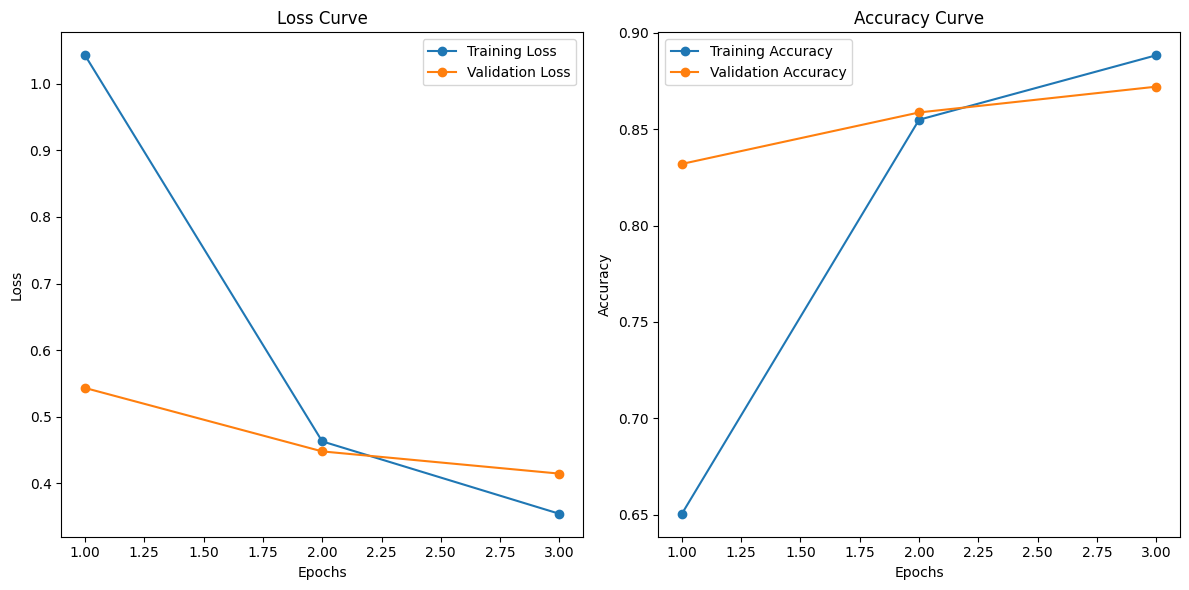

In [11]:
# Plot the training and validation curves
plot_metrics(history_2)

#### Plotting Confusion Matrix

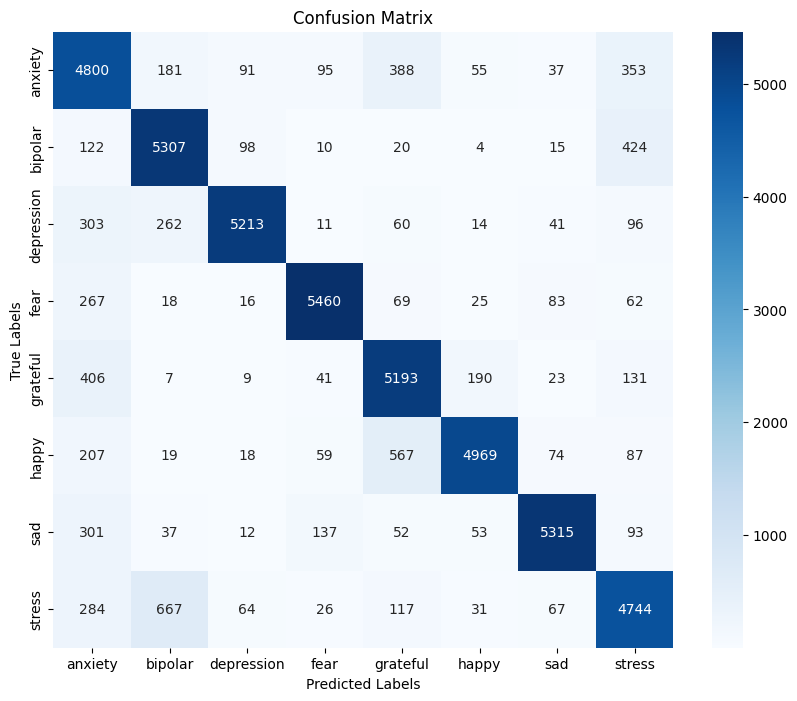

In [12]:
num_classes = 8
plot_confusion_matrix(history_2, num_classes, label_encoder=label_encoder)

#### Save Model 02

In [13]:
import os
import joblib
output_dir = "/kaggle/working/model_2"
os.makedirs(output_dir, exist_ok=True)

torch.save(model_2.state_dict(), f"{output_dir}/bert_emotion_classifier_v2.pt")
# torch.save(model_2.state_dict(), f"{output_dir}/bert_emotion_classifier_v2.bin")
tokenizer.save_pretrained(f"{output_dir}/bert_tokenizer") 
joblib.dump(label_encoder, f"{output_dir}/label_encoder.pkl")

['/kaggle/working/model_2/label_encoder.pkl']

#### Download Model 02

In [14]:
import shutil
shutil.make_archive("BERT_emotion_classifier_v2", 'zip', output_dir)

'/kaggle/working/BERT_emotion_classifier_v2.zip'

In [ ]:
from IPython.display import FileLink
FileLink(r'BERT_emotion_classifier_v2.zip')